In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

2024-05-27 19:19:42.144382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 19:19:42.164867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 19:19:42.528562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#create synthetic time series random uniform integers
n = 1000
data = np.random.randint(1, 6, n)

#select random timewindows of length 5 without overlapping
motif_indexes = []
motif_pattern = [1,1,1,1,1]
p = len(motif_pattern)

max_interval = n//20
print(max_interval)
last_index = 0
while True:
    index_interval = np.random.randint(p+4, p + max_interval)
    if last_index + index_interval + p > n:
        break
    last_index = last_index + index_interval
    motif_indexes.append(last_index)

motif_indexes

50


[51,
 91,
 120,
 138,
 158,
 171,
 204,
 255,
 268,
 315,
 346,
 371,
 387,
 434,
 462,
 477,
 512,
 547,
 565,
 590,
 618,
 658,
 702,
 738,
 776,
 804,
 845,
 879,
 891,
 914,
 939,
 974]

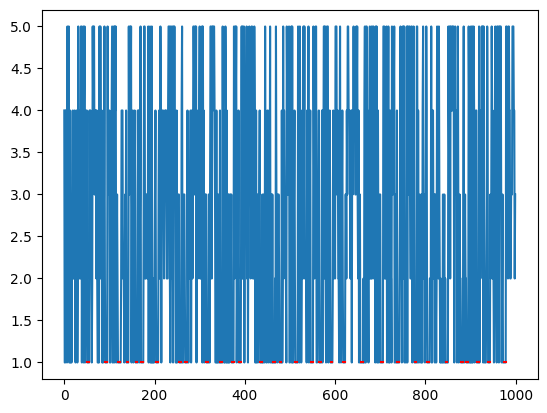

In [3]:
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes:
    data[idx:idx+p] = motif_pattern

#introduce clue in the data
for idx in motif_indexes:
    data[idx-5:idx-2] = [1,2,3]

#plot the data and in red the motif pattern
plt.plot(data)
for idx in motif_indexes:
    plt.plot(range(idx, idx+p), motif_pattern, 'r')

In [4]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data, past_window, step, forward_window, motif_indexes):
    X1, X2, y1, y = list(), list(), list(), list()
    for idx in range(len(data) - past_window - 1):
        if idx % step != 0:
            continue
    
        next_matches = [motif_idx for motif_idx in motif_indexes if motif_idx > idx + past_window]
        if not next_matches:
            continue #no match
        next_match = next_matches[0]
        if next_match > idx + past_window + forward_window:
            next_match = -1 #no match in forward window

        data_x1 = data[idx:idx+past_window]
        data_x2 = [motif_idx for motif_idx in motif_indexes if motif_idx <= idx+past_window]
        data_y1 = data[idx+past_window]
        data_y = next_match
        X1.append(data_x1)
        X2.append(data_x2)
        y1.append(data_y1)
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2), np.array(y1), np.array(y)

In [5]:
past_window = 100 #window size
step = 1 #step size for the sliding window
forward_window = 50 #
X1, X2, y1, y  = create_dataset(data, past_window=past_window, step=step, forward_window=forward_window, motif_indexes=motif_indexes)
print(X1[0], X2[0], y1[0], y[0])

[4 1 1 4 2 4 1 5 3 4 5 1 1 4 1 3 1 3 3 4 2 3 2 4 2 1 3 4 3 1 2 5 3 2 3 4 2
 5 5 1 3 4 5 1 4 5 1 2 3 4 4 1 1 1 1 1 4 2 4 3 2 1 2 5 4 5 5 3 4 3 4 2 4 2
 1 1 2 1 5 2 5 3 2 4 1 3 1 2 3 5 2 1 1 1 1 1 5 3 3 3] [51 91 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1] 4 120


In [6]:
#reshape input to be [samples, time steps, features]
X1 = np.reshape(X1, (X1.shape[0],  X1.shape[1], 1))
X2 = np.reshape(X2, (X2.shape[0],  X2.shape[1], 1))

In [7]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [8]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

def create_model(hp):
    model = Sequential()
    model.add(Input(shape=(X2.shape[1], X2.shape[2])))
    model.add(Masking(mask_value=-1))
    units = hp.Int('units', min_value=10, max_value=50, step=10)
    model.add(LSTM(units=units, activation='relu', return_sequences=False))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mean_absolute_error', 'root_mean_squared_error', 'r2_score'])
    return model

In [9]:
import collections
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import pickle


class CVTuner(kt.engine.tuner.Tuner):

    def run_trial(self, trial, x, y, *args, **kwargs):
        original_callbacks = kwargs.pop("callbacks", [])

        metrics = collections.defaultdict(list)
        batch_size = trial.hyperparameters.Int('batch_size', 32, 64, step=32)
        epochs = trial.hyperparameters.Int('epochs', 500, 500, step=100)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        for train_indices, test_indices in cv.split(x):
            X_train, X_test = x[train_indices], x[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=original_callbacks)
            val_loss, val_mae, val_rmse, val_r2 = model.evaluate(X_test, y_test) 
            metrics["val_loss"].append(val_loss)
            metrics["val_mae"].append(val_mae)
            metrics["val_rmse"].append(val_rmse)
            metrics["val_r2"].append(val_r2)
            print(f"val_loss: {val_loss}, val_mae: {val_mae}, val_rmse: {val_rmse}, val_r2: {val_r2}")

        self.save_model(trial, model)
        return {name: np.mean(values) for name, values in metrics.items()}
        
    
    def save_model(self, trial, model):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

tuner = CVTuner(
  hypermodel=create_model,
  oracle=kt.oracles.GridSearchOracle(
    objective='val_loss',
    max_trials=None))

log_dir = "./logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

tuner.search(
        x=X2,
        y=y,
        callbacks=[tensorboard_callback],
    )


Trial 6 Complete [00h 03m 06s]
val_loss: 37730.4750005722

Best val_loss So Far: 241.87324390411376
Total elapsed time: 00h 23m 29s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
20                |10                |units
0.001             |0.01              |learning_rate
32                |32                |batch_size
500               |500               |epochs

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 43328.9648 - mean_absolute_error: 200.3814 - r2_score: -16.8594 - root_mean_squared_error: 208.1124
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 37507.9766 - mean_absolute_error: 187.2518 - r2_score: -14.1232 - root_mean_squared_error: 193.5380
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31759.8242 - mean_absolute_error: 173.1237 - r2_score: -12.2918 - root_mean_squared_error: 178.1300
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26236.2012 - mean_absolute_error: 157.6772 - r2_score: -10.3768 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 859.2819 - mean_absolute_error: 5.7165 - r2_score: 0.6841 - root_mean_squared_error: 28.1166 
Epoch 222/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 350.8335 - mean_absolute_error: 3.5895 - r2_score: 0.8648 - root_mean_squared_error: 16.2968
Epoch 223/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 351.9599 - mean_absolute_error: 3.7756 - r2_score: 0.8661 - root_mean_squared_error: 16.5443
Epoch 224/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 831.2452 - mean_absolute_error: 5.9120 - r2_score: 0.6993 - root_mean_squared_error: 27.6898 
Epoch 225/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 252.9126 - mean_absolute_error: 3.4236 - r2_score: 0.9013 - root_mean_squared_error: 12.9569
Epoch 226/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 243.9159 - mean_absolute_error: 3.0492 - r2_score: 0.9048 - root_mean_squared_error: 12.6493
Epoch 227/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 516.2919 - mean_absolute_error: 4.

KeyboardInterrupt: 

In [10]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0000 summary
Hyperparameters:
units: 10
learning_rate: 0.01
batch_size: 32
epochs: 500
Score: 241.87324390411376

Trial 0004 summary
Hyperparameters:
units: 20
learning_rate: 0.01
batch_size: 32
epochs: 500
Score: 534.6246826171875

Trial 0002 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 32
epochs: 500
Score: 25075.88262710571

Trial 0005 summary
Hyperparameters:
units: 20
learning_rate: 0.01
batch_size: 64
epochs: 500
Score: 37730.4750005722

Trial 0001 summary
Hyperparameters:
units: 10
learning_rate: 0.01
batch_size: 64
epochs: 500
Score: 75061.3268005371

Trial 0003 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 64
epochs: 500
Score: 167123.26319885254

Trial 0006 summary
Hyperparameters:
units: 20
learning_rate: 0.001
batch_size: 32
epochs: 500


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 31, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.76 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984 (3.84 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 845.0618 - mean_absolute_error: 24.1549 - r2_score: -1.2240 - root_mean_squared_error: 29.0696
850.5797729492188 24.394094467163086 29.164701461791992 -0.884016752243042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 407.2681 - mean_absolute_error: 19.1836 - r2_score: -1.2125 - root_mean_squared_error: 20.1787
398.728759765625 18.941667556762695 19.96819305419922 -1.119126319885254
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42.3459 - mean_absolute_error: 5.4048 - r2_score: 0.7894 - root_mean_squared_error: 6.4511


49.77138137817383 5.754687309265137 7.0548834800720215 0.7971354126930237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.9821 - mean_absolute_error: 6.6798 - r2_score: 0.6532 - root_mean_squared_error: 8.1827
65.13741302490234 6.55230712890625 8.070775032043457 0.6607426404953003
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.0022 - mean_absolute_error: 3.4707 - r2_score: 0.8900 - root_mean_squared_error: 3.7418
13.843278884887695 3.4551913738250732 3.720655679702759 0.8883606195449829
[2.75612121e+02 1.18195896e+01 1.35958417e+01 6.86191201e-02] [319.24037232   8.28652677   9.52707774   0.8799519 ]
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


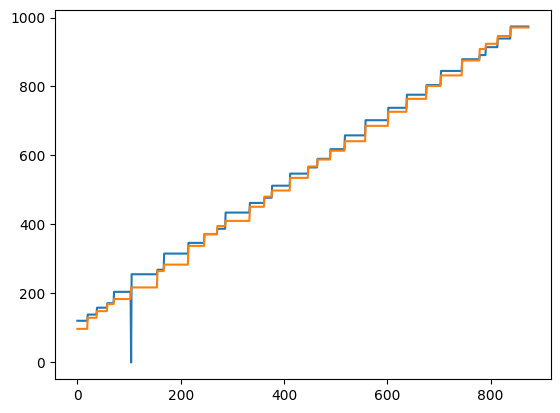

In [15]:
cv = BlockingTimeSeriesSplit(5)
scores = []
for train_indices, test_indices in cv.split(X2):
    val_loss, val_mae, val_rmse, val_r2 = best_model.evaluate(X2[test_indices], y[test_indices])
    scores.append((val_loss, val_mae, val_rmse, val_r2))
    print(val_loss, val_mae, val_rmse, val_r2)
print(np.mean(scores, axis=0), np.std(scores, axis=0))

#plot the predictions
predictions = best_model.predict(X2)
plt.plot(y)
plt.plot(predictions)
plt.show()

In [ ]:
def create_model_embeddinglstm(hp):
    model = Sequential()
    model.add(LSTM(units=50, activation='tanh', return_sequences=False))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

import keras_tuner as kt
from keras.callbacks import EarlyStopping

tuner= kt.RandomSearch(
        create_model_embeddinglstm,
        objective='mae',
        max_trials=5,
        executions_per_trial=3,
        project_name = 'embeddinglstm'
        )

tuner.search(
        x=X1,
        y=y1,
        epochs=10,
        batch_size=64
        )


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y1_train_pred = best_model.predict(X1_train)
mse = mean_squared_error(y1_train, y1_train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y1_train, y1_train_pred)
r2 = r2_score(y1_train, y1_train_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y1_train, label='True')
plt.plot(y1_train_pred, label='Predicted')



In [ ]:
#get the embedding layer
embeddings = best_model.layers[1].get_weights()[0]
#embeddings to 1d array
embeddings = embeddings.flatten()
embeddings

In [ ]:
#join the embeddings with the motif indexes
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_train, label='True')
plt.plot(y_train_pred, label='Predicted')

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')


In [ ]:
#join the embeddings with the motif indexes and the motif pattern
X_train = []
for x2 in X2_train:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_train.append(x2)

X_train = np.array(X_train)

X_test = []
for x2 in X2_test:
    #concat embeddigs with x2
    x2 = x2.flatten()
    x2 = np.concatenate((embeddings, x2, motif_pattern))
    X_test.append(x2)

X_test = np.array(X_test)
X_train.shape
